Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

## Dependencies

In [1]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

## Plotting and metrics imports
from metrics import get_plotting_color, plot_examples, plot_class_distribution, plot_results, plot_scores_per_class, plot_weights

## Other functions imports
from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity, calculate_grad_snr

## MLP imports
from MLP import MLP, NodePerturbMLP, KolenPollackMLP

## Data

In [2]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [3]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


## Hyperparams

In [4]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

## Backprop

In [5]:
rng_bp2 = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp2.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
test_loss_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], test_loss_backprop[:], _) = \
    netbackprop.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  0.44 .
...completed  2.0  epochs of training. Current loss:  0.32 .
...completed  3.0  epochs of training. Current loss:  0.27 .
...completed  4.0  epochs of training. Current loss:  0.24 .
...completed  5.0  epochs of training. Current loss:  0.22 .
...completed  6.0  epochs of training. Current loss:  0.2 .
...completed  7.0  epochs of training. Current loss:  0.19 .
...completed  8.0  epochs of training. Current loss:  0.19 .
...completed  9.0  epochs of training. Current loss:  0.18 .
...completed  10.0  epochs of training. Current loss:  0.18 .
...completed  11.0  epochs of training. Current loss:  0.17 .
...completed  12.0  epochs of training. Current loss:  0.17 .
...completed  13.0  epochs of training. Current loss:  0.17 .
...completed  14.0  epochs of training. Current loss:  0.16 .
...completed  15.0  epochs of training. Current loss:  0.16 .
...completed  16.0  epochs of training. Current loss:  0.16

## Online Learning

In [14]:
# create a network and train it using backprop
netonline = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_online, accuracy_online, test_loss_online, _) = \
    netonline.train_online(rng_bp2, train_images, train_labels, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=0.01, max_it=numupdates, conv_loss = 1e-2, algorithm='backprop', noise=noise, \
                      report=report, report_rate=100)

Training starting...
...completed  1000  iterations of training data (single images). Current loss:  0.9 .
...completed  2000  iterations of training data (single images). Current loss:  0.45 .
...completed  3000  iterations of training data (single images). Current loss:  0.96 .
...completed  4000  iterations of training data (single images). Current loss:  0.92 .
...completed  5000  iterations of training data (single images). Current loss:  0.25 .
...completed  6000  iterations of training data (single images). Current loss:  0.11 .
...completed  7000  iterations of training data (single images). Current loss:  1.02 .
...completed  8000  iterations of training data (single images). Current loss:  0.14 .
...completed  9000  iterations of training data (single images). Current loss:  0.25 .
...completed  10000  iterations of training data (single images). Current loss:  0.06 .
...completed  11000  iterations of training data (single images). Current loss:  0.11 .
...completed  11770  

## Non-stationary Data

In [7]:
# create a network and train it using backprop
netnonstat = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_nonstat, accuracy_nonstat, test_loss_nonstat, _) = \
    netnonstat.train_nonstat_data(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=1)

Training starting...
...completed  1  epochs of training. Current loss:  0.19 .
...completed  2  epochs of training. Current loss:  0.13 .
...completed  3  epochs of training. Current loss:  0.11 .
...completed  4  epochs of training. Current loss:  0.09 .
...completed  5  epochs of training. Current loss:  0.08 .
...completed  6  epochs of training. Current loss:  0.08 .
...completed  7  epochs of training. Current loss:  0.07 .
...completed  8  epochs of training. Current loss:  0.07 .
...completed  9  epochs of training. Current loss:  0.07 .
...completed  10  epochs of training. Current loss:  0.06 .
...completed  11  epochs of training. Current loss:  0.06 .
...completed  12  epochs of training. Current loss:  0.06 .
...completed  13  epochs of training. Current loss:  0.06 .
...completed  14  epochs of training. Current loss:  0.43 .
...completed  15  epochs of training. Current loss:  0.29 .
...completed  16  epochs of training. Current loss:  0.24 .
...completed  17  epochs of 

## Noisy Input Data

In [8]:
# create a network and train it using backprop
netnoisy = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses__noisy_input, accuracy_noisy_input, test_loss_noisy_input, _) = \
    netnoisy.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

Training starting...
...completed  1.0  epochs of training. Current loss:  0.43 .
...completed  2.0  epochs of training. Current loss:  0.32 .
...completed  3.0  epochs of training. Current loss:  0.28 .
...completed  4.0  epochs of training. Current loss:  0.26 .
...completed  5.0  epochs of training. Current loss:  0.24 .
...completed  6.0  epochs of training. Current loss:  0.23 .
...completed  7.0  epochs of training. Current loss:  0.22 .
...completed  8.0  epochs of training. Current loss:  0.22 .
...completed  9.0  epochs of training. Current loss:  0.21 .
...completed  10.0  epochs of training. Current loss:  0.21 .
...completed  11.0  epochs of training. Current loss:  0.21 .
...completed  12.0  epochs of training. Current loss:  0.2 .
...completed  13.0  epochs of training. Current loss:  0.2 .
...completed  14.0  epochs of training. Current loss:  0.2 .
...completed  15.0  epochs of training. Current loss:  0.2 .
...completed  16.0  epochs of training. Current loss:  0.19 .


## Node Perturbation

In [9]:
# @title Train and observe the performance of NodePerturbMLP

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
with contextlib.redirect_stdout(io.StringIO()):
    netnodeperturb = NodePerturbMLP(rng_np, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
    (losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
        netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                             report=report, report_rate=rep_rate)


KeyboardInterrupt: 

## Kolen-Pollack

In [10]:
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
test_loss_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], test_loss_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng_bp2 = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp2.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
test_loss_backprop = np.zeros((numepochs,))

Training starting...
...completed  1.0  epochs of training. Current loss:  0.57 .
...completed  2.0  epochs of training. Current loss:  0.39 .
...completed  3.0  epochs of training. Current loss:  0.31 .
...completed  4.0  epochs of training. Current loss:  0.27 .
...completed  5.0  epochs of training. Current loss:  0.25 .
...completed  6.0  epochs of training. Current loss:  0.23 .
...completed  7.0  epochs of training. Current loss:  0.22 .
...completed  8.0  epochs of training. Current loss:  0.21 .
...completed  9.0  epochs of training. Current loss:  0.2 .
...completed  10.0  epochs of training. Current loss:  0.19 .
...completed  11.0  epochs of training. Current loss:  0.19 .
...completed  12.0  epochs of training. Current loss:  0.18 .
...completed  13.0  epochs of training. Current loss:  0.18 .
...completed  14.0  epochs of training. Current loss:  0.18 .
...completed  15.0  epochs of training. Current loss:  0.18 .
...completed  16.0  epochs of training. Current loss:  0.17

## Results

In [29]:
# Calculate the moving average
from scipy.ndimage import uniform_filter1d
window_size = 100
losses_online_mean = uniform_filter1d(losses_online, size=window_size)

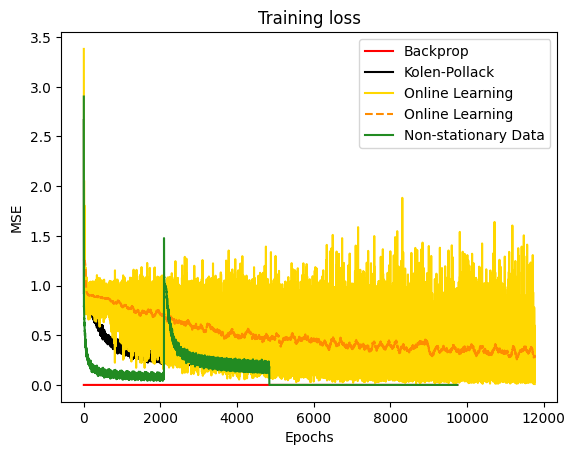

In [30]:
#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.plot(losses_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.plot(losses_online, label="Online Learning", color='gold')
plt.plot(losses_online_mean, label="Online Learning Smoothed", color='darkorange', linestyle='dashed')
plt.plot(losses_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(losses_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

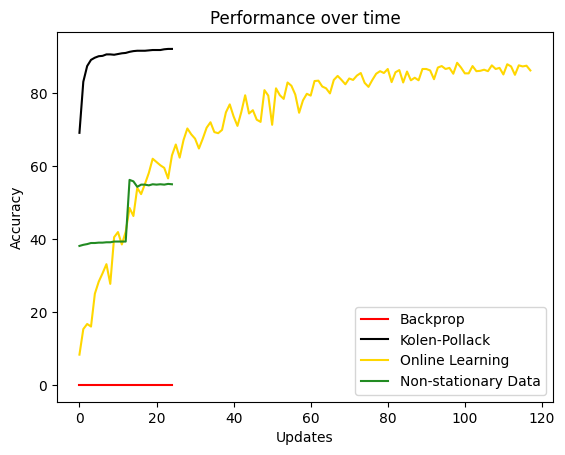

In [16]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(accuracy_backprop, label="Backprop", color='r')
plt.plot(accuracy_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(accuracy_node_perturb, label="Node Perturbation", color='c')
plt.plot(accuracy_online, label="Online Learning", color='gold')
plt.plot(accuracy_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(accuracy_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Updates")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Performance over time")
plt.show()

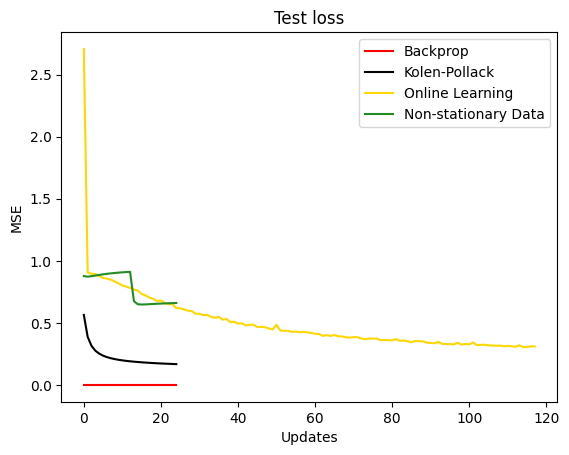

In [17]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(test_loss_backprop, label="Backprop", color='r')
plt.plot(test_loss_kolepoll, label="Kolen-Pollack", color='k')
# plt.plot(test_loss_node_perturb, label="Node Perturbation", color='c')
plt.plot(test_loss_online, label="Online Learning", color='gold')
plt.plot(test_loss_nonstat, label="Non-stationary Data", color='forestgreen')
# plt.plot(test_loss_noisy_input, label="Noisy Input Data", color='dodgerblue')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")
plt.show()